### Perguntas a serem respondidas
---


1. Feature mais importante

2. Justificativa técnica

3. Interpretação de negócio

4. Ação sugerida

#### Configurações para importar dados

In [5]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Conectar ao banco de dados SQLite
conn = sqlite3.connect(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\seguros.db')

df_dict = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\backend\data\raw\P18_dicionario_dados.csv', encoding='utf-8', sep=',')
df_cancel = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\backend\data\raw\P18_cancelamentos.csv', encoding='utf-8', sep=',')
df_contratos = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\backend\data\raw\P18_contratos.csv', encoding='utf-8', sep=',')
df_clientes= pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\backend\data\raw\P18_clientes.csv', encoding='utf-8', sep=',')
df_clientes.to_sql('clientes', conn, if_exists='replace', index=False)
df_contratos.to_sql('contratos', conn, if_exists='replace', index=False)
df_cancel.to_sql('cancelamentos', conn, if_exists='replace', index=False)

# Carregar as tabelas como DataFrames do pandas
df_clientes = pd.read_sql_query("SELECT * FROM clientes", conn)
df_contratos = pd.read_sql_query("SELECT * FROM contratos", conn)
df_cancel = pd.read_sql_query("SELECT * FROM cancelamentos", conn)



### Query do Modelo

In [28]:
query = """ 
SELECT
  substr(c.id_cliente, 2) AS id_cliente,
  cl.genero,
  cl.data_nascimento,
  CAST(strftime('%Y', 'now') AS INTEGER) - CAST(strftime('%Y', cl.data_nascimento) AS INTEGER) AS idade,
  cl.renda_mensal,
  cl.nivel_educacional,
  cl.qtd_dependentes,
  c.tipo_seguro,
  c.valor_premio_mensal,
  c.satisfacao_ultima_avaliacao,
  c.canal_venda,
  c.renovado_automaticamente,
  ca.motivo_cancelamento,
  DATE(c.data_inicio) AS inicio,
  DATE(c.data_fim) AS fim,
  julianday(c.data_fim) - julianday(c.data_inicio) AS duracao_dias,

  CASE 
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) <= 31 THEN 'Mensal'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 32 AND 92 THEN 'Trimestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 93 AND 183 THEN 'Semestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 184 AND 366 THEN 'Anual'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) > 366 THEN 'Bianual'
    ELSE 'Indefinido'
  END AS tipo_duracao,

  CASE 
    WHEN ca.id_contrato IS NOT NULL THEN 1
    ELSE 0
  END AS cancelado

FROM contratos c
JOIN clientes cl ON c.id_cliente = cl.id_cliente
LEFT JOIN cancelamentos ca ON c.id_contrato = ca.id_contrato

-- ✅ Mantém apenas contratos ativos ou cancelados
WHERE ca.id_contrato IS NOT NULL
   OR DATE('now') BETWEEN DATE(c.data_inicio) AND DATE(c.data_fim)
;

"""
df = pd.read_sql_query(query, conn)
df['id_cliente'] = df['id_cliente'].astype(int)
df = df.drop('data_nascimento', axis=1)
df = df.drop('id_cliente', axis=1)
df = df.drop('motivo_cancelamento', axis=1)
df = df.drop('inicio', axis=1)
df = df.drop('fim', axis=1)
df = df.drop('duracao_dias', axis=1)


df


,genero,idade,renda_mensal,nivel_educacional,qtd_dependentes,tipo_seguro,valor_premio_mensal,satisfacao_ultima_avaliacao,canal_venda,renovado_automaticamente,tipo_duracao,cancelado
0,Outro,66,12406.88,Técnico,2,Empresarial,892.30,Média,Site,0,Semestral,1
1,Outro,67,18950.78,Superior,3,Vida,962.07,Baixa,Agência Física,0,Bianual,0
2,Feminino,46,17135.37,Técnico,3,Vida,996.09,Baixa,App,1,Semestral,1
3,Masculino,77,13945.07,Pós,2,Saúde,1158.48,Baixa,Site,1,Bianual,0
4,Masculino,19,11315.19,Superior,0,Vida,840.08,Média,Site,1,Anual,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6088,Masculino,19,15801.76,Fundamental,0,Vida,599.48,Alta,Agência Física,1,Bianual,1
6089,Masculino,57,3167.47,Superior,1,Residencial,334.17,Baixa,Agência Física,0,Semestral,1
6090,Outro,45,1655.74,Médio,1,Vida,897.26,Alta,Site,0,Bianual,0
6091,Outro,45,16652.42,Médio,0,Vida,1478.74,Alta,Agência Física,0,Bianual,1


### Modelo

In [29]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 3. Aplica o SMOTE para balancear a base
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Divide os dados balanceados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Treina o modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


# 6. Avalia o modelo
y_pred = model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70       678
           1       0.76      0.57      0.65       752

    accuracy                           0.68      1430
   macro avg       0.69      0.68      0.67      1430
weighted avg       0.69      0.68      0.67      1430

[[541 137]
 [325 427]]


### Aplicando SHAP no Modelo

renda_mensal: 0.1319
valor_premio_mensal: 0.1296
idade: 0.1204
tipo_duracao_Bianual: 0.0696
tipo_duracao_Semestral: 0.0639
qtd_dependentes: 0.0606
tipo_duracao_Anual: 0.0296
renovado_automaticamente: 0.0288
satisfacao_ultima_avaliacao_Baixa: 0.0229
satisfacao_ultima_avaliacao_Média: 0.0201
genero_Masculino: 0.0196
genero_Feminino: 0.0194
satisfacao_ultima_avaliacao_Alta: 0.0189
canal_venda_Agência Física: 0.0186
genero_Outro: 0.0185
tipo_seguro_Auto: 0.0184
canal_venda_Corretor: 0.0183
tipo_seguro_Empresarial: 0.0180
tipo_seguro_Vida: 0.0179
canal_venda_App: 0.0176
tipo_seguro_Saúde: 0.0175
canal_venda_Site: 0.0175
tipo_seguro_Residencial: 0.0174
nivel_educacional_Fundamental: 0.0174
nivel_educacional_Superior: 0.0171
nivel_educacional_Técnico: 0.0171
nivel_educacional_Pós: 0.0168
nivel_educacional_Médio: 0.0167
SHAP values shape: (500, 28, 2)
SHAP[1] shape: (28, 2)
X_test_sample shape: (500, 28)


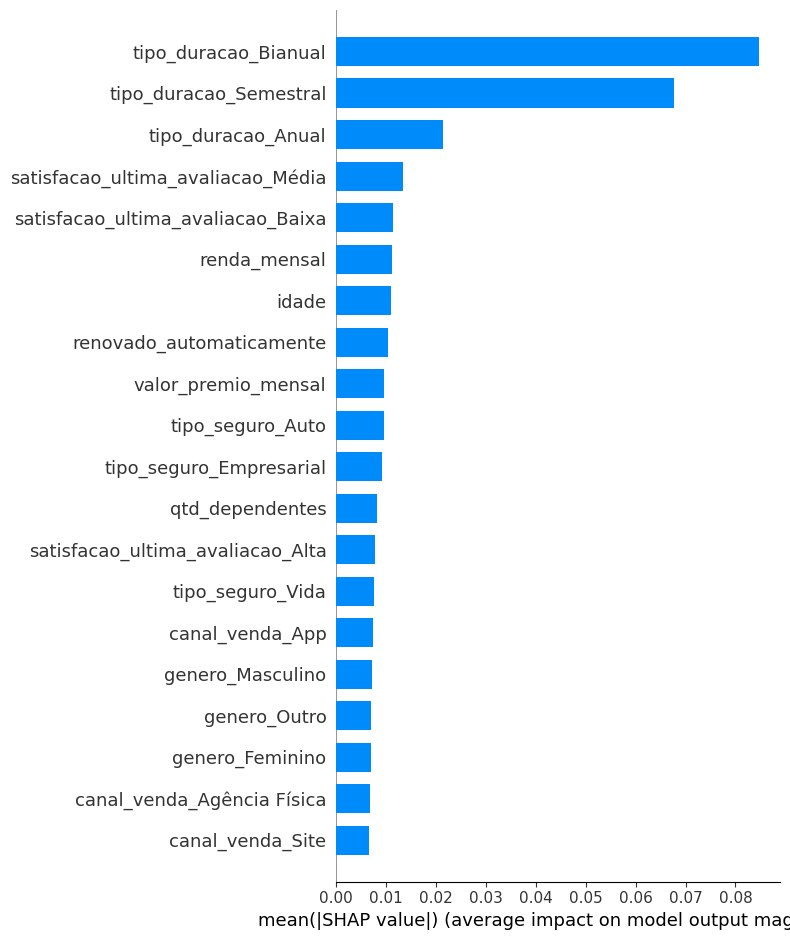

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       694
           1       0.73      0.58      0.64       742

    accuracy                           0.67      1436
   macro avg       0.68      0.67      0.67      1436
weighted avg       0.68      0.67      0.67      1436

📉 Matriz de Confusão:
 [[532 162]
 [312 430]]


In [7]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Define variáveis categóricas
categorical_features = [
    "genero",
    "nivel_educacional",
    "tipo_seguro",
    "satisfacao_ultima_avaliacao",
    "canal_venda",
    "tipo_duracao"
]

# 3. Cria ColumnTransformer
encoder = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop=None, sparse_output=False), categorical_features)
    ],
    remainder="passthrough"
)

# 4. Aplica transformação e obtém nomes corretos das colunas
X_encoded = encoder.fit_transform(X)

# Pega os nomes das features do OneHotEncoder
encoded_feature_names = encoder.named_transformers_["onehot"].get_feature_names_out(categorical_features)

# Agora adiciona os nomes das colunas que foram passadas direto com passthrough
# Elas são todas as colunas de X exceto as categóricas
numeric_features = [col for col in X.columns if col not in categorical_features]
all_feature_names = list(encoded_feature_names) + numeric_features

# 5. Aplica SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 6. Divide treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 7. Treina modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 8. Prepara DataFrame com nomes corretos para SHAP
X_test_df = pd.DataFrame(X_test, columns=all_feature_names)

sample_size = min(500, X_test_df.shape[0])
sample_idx = np.random.choice(X_test_df.shape[0], size=sample_size, replace=False)
X_test_sample = X_test_df.iloc[sample_idx]

# 9. Calcula SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample)

# 10. Gráfico SHAP para a classe 1 (cancelado)
importances = model.feature_importances_
for name, imp in sorted(zip(all_feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {imp:.4f}")
    
print("SHAP values shape:", np.array(shap_values).shape)  # Deve ser (2, 500, n)
print("SHAP[1] shape:", shap_values[1].shape)              # (500, ?)
print("X_test_sample shape:", X_test_sample.shape)         # (500, 23)
shap_arr = shap_values[:, :, 1]  # Pega só a contribuição da classe "1"

shap.summary_plot(shap_arr, X_test_sample, plot_type="bar", max_display=20)

# 11. Avaliação do modelo
y_pred = model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("📉 Matriz de Confusão:\n", cm)


In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = [
    "genero", "nivel_educacional", "tipo_seguro",
    "satisfacao_ultima_avaliacao", "canal_venda", "tipo_duracao"
]

encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 2.1 Recupera nomes das colunas (necessário para SHAP)
onehot_names = encoder.named_transformers_["onehot"].get_feature_names_out(categorical_features)
numeric_features = [col for col in X.columns if col not in categorical_features]
all_feature_names = np.concatenate([onehot_names, numeric_features])

# 3. Aplica SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_encoded, y)

# 4. Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 5. Treina o modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
X_test_df = pd.DataFrame(X_test, columns=all_feature_names)


explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test_df)


In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = [
    "genero", "nivel_educacional", "tipo_seguro",
    "satisfacao_ultima_avaliacao", "canal_venda", "tipo_duracao"
]

encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop=None), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 2.1 Recupera nomes das colunas (necessário para SHAP)
onehot_names = encoder.named_transformers_["onehot"].get_feature_names_out(categorical_features)
numeric_features = [col for col in X.columns if col not in categorical_features]
all_feature_names = np.concatenate([onehot_names, numeric_features])

# 3. Aplica SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_encoded, y)

# 4. Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 5. Treina o modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 6. Cria DataFrame do teste com nomes das colunas
X_test_df = pd.DataFrame(X_test, columns=all_feature_names)

# 7. Amostra para SHAP (mais rápido)
sample_size = min(500, X_test_df.shape[0])
sample_idx = np.random.choice(X_test_df.shape[0], size=sample_size, replace=False)
X_test_sample = X_test_df.iloc[sample_idx]

# 8. Explicador SHAP otimizado para RandomForest
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample)

# 9. Plota summary plot só da amostra
print(all_feature_names)
print(X_test_df.shape)
print(X_test_sample.shape)
importances = model.feature_importances_
for name, imp in sorted(zip(all_feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {imp:.4f}")
    
print("SHAP values shape:", np.array(shap_values).shape)  # Deve ser (2, 500, n)
print("SHAP[1] shape:", shap_values[1].shape)              # (500, ?)
print("X_test_sample shape:", X_test_sample.shape)         # (500, 23)
shap_arr = shap_values[:, :, 1]  # Pega só a contribuição da classe "1"

shap.summary_plot(shap_arr, X_test_sample, plot_type="bar", max_display=20)

print(X_test_df.describe())


cm = confusion_matrix(y_test, y_pred)
print("📉 Matriz de Confusão:\n", cm)

KeyboardInterrupt: 

In [ ]:
X_test_df.columns

Index(['genero_Masculino', 'genero_Outro', 'nivel_educacional_Médio',
       'nivel_educacional_Pós', 'nivel_educacional_Superior',
       'nivel_educacional_Técnico', 'tipo_seguro_Empresarial',
       'tipo_seguro_Residencial', 'tipo_seguro_Saúde', 'tipo_seguro_Vida',
       'satisfacao_ultima_avaliacao_Baixa',
       'satisfacao_ultima_avaliacao_Média', 'canal_venda_App',
       'canal_venda_Corretor', 'canal_venda_Site', 'tipo_duracao_Bianual',
       'tipo_duracao_Semestral', 'idade', 'renda_mensal', 'qtd_dependentes',
       'valor_premio_mensal', 'renovado_automaticamente', 'duracao_dias'],
      dtype='object')

In [ ]:
X_test_df.corr()

,genero_Feminino,genero_Masculino,genero_Outro,nivel_educacional_Fundamental,nivel_educacional_Médio,nivel_educacional_Pós,nivel_educacional_Superior,nivel_educacional_Técnico,tipo_seguro_Auto,tipo_seguro_Empresarial,...,canal_venda_Corretor,canal_venda_Site,tipo_duracao_Anual,tipo_duracao_Bianual,tipo_duracao_Semestral,idade,renda_mensal,qtd_dependentes,valor_premio_mensal,renovado_automaticamente
genero_Feminino,1.000000,-0.476155,-0.489512,0.022293,-0.023525,0.039440,0.019088,-0.057769,-0.006106,-0.041923,...,-0.017996,-0.043447,-0.041281,0.049266,-0.013639,0.026889,-0.026777,0.009283,0.016423,0.040610
genero_Masculino,-0.476155,1.000000,-0.533716,0.025764,-0.055476,-0.041383,0.006714,0.064728,-0.009619,0.049565,...,0.035429,0.008312,0.041294,-0.039468,0.002235,-0.067904,-0.034523,-0.018429,0.000878,-0.016093
genero_Outro,-0.489512,-0.533716,1.000000,-0.046987,0.077634,0.003107,-0.025015,-0.008631,0.015410,-0.008834,...,-0.017826,0.033539,-0.001249,-0.008240,0.010900,0.041476,0.059985,0.009348,-0.016664,-0.023095
nivel_educacional_Fundamental,0.022293,0.025764,-0.046987,1.000000,-0.273684,-0.258501,-0.255548,-0.258647,0.014862,-0.012235,...,-0.030528,-0.000654,0.020961,-0.008920,-0.011786,0.001323,-0.023118,-0.010717,-0.036685,-0.014355
nivel_educacional_Médio,-0.023525,-0.055476,0.077634,-0.273684,1.000000,-0.247078,-0.249292,-0.246944,0.003366,0.040026,...,0.002835,-0.019363,-0.024666,0.023047,-0.000720,-0.001893,0.033333,-0.016693,-0.034793,-0.002108
nivel_educacional_Pós,0.039440,-0.041383,0.003107,-0.258501,-0.247078,1.000000,-0.236594,-0.235274,-0.011434,-0.046422,...,-0.035055,0.052674,-0.029138,0.001765,0.028746,-0.003261,-0.029063,-0.015530,0.010693,-0.001419
nivel_educacional_Superior,0.019088,0.006714,-0.025015,-0.255548,-0.249292,-0.236594,1.000000,-0.236886,-0.021380,0.007186,...,0.008937,-0.051953,-0.027948,0.011683,0.015958,0.016976,-0.038768,0.024378,0.074691,0.024700
nivel_educacional_Técnico,-0.057769,0.064728,-0.008631,-0.258647,-0.246944,-0.235274,-0.236886,1.000000,0.013663,0.010819,...,0.055394,0.019988,0.060430,-0.027827,-0.031523,-0.013164,0.057829,0.019677,-0.010788,-0.005968
tipo_seguro_Auto,-0.006106,-0.009619,0.015410,0.014862,0.003366,-0.011434,-0.021380,0.013663,1.000000,-0.263672,...,-0.010699,0.032417,-0.004925,0.029651,-0.029263,-0.002652,-0.015585,0.040812,-0.005821,-0.041270
tipo_seguro_Empresarial,-0.041923,0.049565,-0.008834,-0.012235,0.040026,-0.046422,0.007186,0.010819,-0.263672,1.000000,...,0.005591,-0.024947,0.017210,-0.007007,-0.010045,-0.026511,-0.005823,-0.046974,-0.001909,0.021624


Essa análise foi para identificar que nem todas as colunas categóricas estavam sendo utilizadas como fator, e o motivo foi porque estava codificado para que o ONeHotEncoder dropasse a primeira coluna.
> a solução foi trocar de drop=First para drop None

> Mais alguns testes para ter sobre o modelo, para termos um desempenho melhor
Remover essas 5 features e reavaliar

Criar novas features derivadas com base nessas

Comparar o desempenho do modelo antes/depois

#### Criando novas Features a partir das com baixo desempenho
- renda_mensal
- qtd_dependentes
- nivel_educacional_Médio
- tipo_seguro_Empresarial
- tipo_seguro_Saúde

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Define variáveis categóricas
categorical_features = [
    "genero", "nivel_educacional", "tipo_seguro",
    "satisfacao_ultima_avaliacao", "canal_venda", "tipo_duracao"
]

# 3. Divide treino/teste
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop=None, sparse_output=False), categorical_features),
        ("num", StandardScaler(), list(set(X.columns) - set(categorical_features)))
    ]
)

# 5. Pipeline completa com modelo
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(class_weight='balanced', max_iter=1000))
])

# 6. Aplica pré-processamento manual para SMOTE
X_train_encoded = preprocessor.fit_transform(X_train_raw)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_encoded, y_train)

# 7. Treina o modelo com os dados balanceados
pipeline.named_steps['model'].fit(X_resampled, y_resampled)

# 8. Previsão
X_test_encoded = preprocessor.transform(X_test_raw)
y_pred = pipeline.named_steps['model'].predict(X_test_encoded)

# 9. Avaliação
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📉 Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# 10. Interpretando os coeficientes
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
numerical_features = list(set(X.columns) - set(categorical_features))
all_features = feature_names + numerical_features

coeffs = pipeline.named_steps['model'].coef_[0]
coef_df = pd.DataFrame({
    'feature': all_features,
    'coef': coeffs
}).sort_values(by="coef", ascending=False)

print("💡 Principais Features que Aumentam o Churn:")
print(coef_df.head(10))

print("\n💡 Principais Features que Reduzem o Churn:")
print(coef_df.tail(10))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       713
           1       0.55      0.62      0.58       516

    accuracy                           0.63      1229
   macro avg       0.63      0.63      0.63      1229
weighted avg       0.64      0.63      0.63      1229

📉 Matriz de Confusão:
[[457 256]
 [197 319]]
💡 Principais Features que Aumentam o Churn:
                              feature      coef
22             tipo_duracao_Semestral  0.869330
11                  tipo_seguro_Saúde  0.132341
10            tipo_seguro_Residencial  0.102506
5               nivel_educacional_Pós  0.100506
6          nivel_educacional_Superior  0.097421
17                    canal_venda_App  0.087484
14  satisfacao_ultima_avaliacao_Baixa  0.078902
18               canal_venda_Corretor  0.072394
9             tipo_seguro_Empresarial  0.046531
1                    genero_Masculino  0.040229

💡 Principais Features que Redu

## 1. Avaliar a necessidade de balanceamento com SMOTE
---

- Analisar o desequilíbrio da variável target (cancelado):

- 2520 cancelados vs. 3660 ativos → classe 1 = 41% → o desequilíbrio existe, mas não é extremo.

- SMOTE pode ser útil, mas teste com e sem:

- Compare o recall, precision, e a matriz de confusão.

- Use stratified k-fold para avaliar a estabilidade dos resultados.

## 2. Refatorar e criar novas features (feature engineering)
---



**Ajustes em features existentes:**

- idade → converter em faixa_etaria (ex: 18-30, 31-45, etc.)

- satisfacao_ultima_avaliacao → converter para score numérico (ex: Baixa = 0, Média = 1, Alta = 2)

***Agrupamentos e interações úteis:**

- renda_por_dependente = renda_mensal / (1 + qtd_dependentes)

- valor_premio_sobre_renda = valor_premio_mensal / renda_mensal

- interacao_idade_renda = idade * renda_mensal (se fizer sentido no seu contexto)

***Indicadores binários inteligentes:**

- faixa_renda_baixa_premio_alto = 1 se valor_premio_sobre_renda > 0.3

- tem_dependentes_e_seguro_vida = 1 se qtd_dependentes > 0 and tipo_seguro == 'Vida'

***Seguros de alto risco (nova variável):**

- Criar feature binária: seguro_alto_risco = 1 se churn_rate_tipo_seguro > 21%


In [33]:
query = """ 
SELECT
  substr(c.id_cliente, 2) AS id_cliente,
  cl.genero,
  cl.data_nascimento,
  CAST(strftime('%Y', 'now') AS INTEGER) - CAST(strftime('%Y', cl.data_nascimento) AS INTEGER) AS idade,
  cl.renda_mensal,
  cl.nivel_educacional,
  cl.qtd_dependentes,
  c.tipo_seguro,
  c.valor_premio_mensal,
  c.satisfacao_ultima_avaliacao,
  c.canal_venda,
  c.renovado_automaticamente,
  ca.motivo_cancelamento,
  DATE(c.data_inicio) AS inicio,
  DATE(c.data_fim) AS fim,
  julianday(c.data_fim) - julianday(c.data_inicio) AS duracao_dias,

  CASE 
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) <= 31 THEN 'Mensal'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 32 AND 92 THEN 'Trimestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 93 AND 183 THEN 'Semestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 184 AND 366 THEN 'Anual'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) > 366 THEN 'Bianual'
    ELSE 'Indefinido'
  END AS tipo_duracao,

  CASE 
    WHEN ca.id_contrato IS NOT NULL THEN 1
    ELSE 0
  END AS cancelado

FROM contratos c
JOIN clientes cl ON c.id_cliente = cl.id_cliente
LEFT JOIN cancelamentos ca ON c.id_contrato = ca.id_contrato

-- ✅ Mantém apenas contratos ativos ou cancelados
WHERE ca.id_contrato IS NOT NULL
   OR DATE('now') BETWEEN DATE(c.data_inicio) AND DATE(c.data_fim)
;

"""
df = pd.read_sql_query(query, conn)
df['id_cliente'] = df['id_cliente'].astype(int)
df = df.drop('data_nascimento', axis=1)
df = df.drop('id_cliente', axis=1)
df = df.drop('motivo_cancelamento', axis=1)
df = df.drop('inicio', axis=1)
df = df.drop('fim', axis=1)


df


,genero,idade,renda_mensal,nivel_educacional,qtd_dependentes,tipo_seguro,valor_premio_mensal,satisfacao_ultima_avaliacao,canal_venda,renovado_automaticamente,duracao_dias,tipo_duracao,cancelado
0,Outro,66,12406.88,Técnico,2,Empresarial,892.30,Média,Site,0,180.0,Semestral,1
1,Outro,67,18950.78,Superior,3,Vida,962.07,Baixa,Agência Física,0,730.0,Bianual,0
2,Feminino,46,17135.37,Técnico,3,Vida,996.09,Baixa,App,1,180.0,Semestral,1
3,Masculino,77,13945.07,Pós,2,Saúde,1158.48,Baixa,Site,1,730.0,Bianual,0
4,Masculino,19,11315.19,Superior,0,Vida,840.08,Média,Site,1,365.0,Anual,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6088,Masculino,19,15801.76,Fundamental,0,Vida,599.48,Alta,Agência Física,1,730.0,Bianual,1
6089,Masculino,57,3167.47,Superior,1,Residencial,334.17,Baixa,Agência Física,0,180.0,Semestral,1
6090,Outro,45,1655.74,Médio,1,Vida,897.26,Alta,Site,0,730.0,Bianual,0
6091,Outro,45,16652.42,Médio,0,Vida,1478.74,Alta,Agência Física,0,730.0,Bianual,1


genero	
idade
renda_mensal	
nivel_educacional - Categorico	5
qtd_dependentes	
tipo_seguro - Categorico	6
valor_premio_mensal	
satisfacao_ultima_avaliacao - Categorico 3	
canal_venda - Categorico	4
renovado_automaticamente	
tipo_duracao - Categorico 	3
cancelado - Target

Criando as novas features

,genero,nivel_educacional,canal_venda,renovado_automaticamente,duracao_dias,cancelado,faixa_etaria,satisfacao_score,renda_por_dependente,valor_premio_sobre_renda,interacao_idade_renda,faixa_renda_baixa_premio_alto,tem_dependentes_e_seguro_vida,seguro_alto_risco
0,Outro,Técnico,Site,0,180.0,1,61-75,1,4135.626667,0.071920,818854.08,0,0,1
1,Outro,Superior,Agência Física,0,730.0,0,61-75,0,4737.695000,0.050767,1269702.26,0,1,1
2,Feminino,Técnico,App,1,180.0,1,46-60,0,4283.842500,0.058131,788227.02,0,1,1
3,Masculino,Pós,Site,1,730.0,0,76+,0,4648.356667,0.083075,1073770.39,0,0,1
4,Masculino,Superior,Site,1,365.0,1,18-30,1,11315.190000,0.074244,214988.61,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,Masculino,Fundamental,Agência Física,1,730.0,1,18-30,2,15801.760000,0.037938,300233.44,0,0,1
6140,Masculino,Superior,Agência Física,0,180.0,1,46-60,0,1583.735000,0.105501,180545.79,0,0,1
6141,Outro,Médio,Site,0,730.0,0,31-45,2,827.870000,0.541909,74508.30,1,1,1
6142,Outro,Médio,Agência Física,0,730.0,1,31-45,2,16652.420000,0.088800,749358.90,0,0,1


##  3. Testar modelos e comparações

#### 3.1 LogisticRegression (já interpretável) 


SEM SMOTE E FEATURES ORIGINAIS

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.85      0.74       708
           1       0.66      0.39      0.49       520

    accuracy                           0.66      1228
   macro avg       0.66      0.62      0.62      1228
weighted avg       0.66      0.66      0.64      1228

📉 Confusion Matrix:
[[604 104]
 [316 204]]
🔎 Métricas:
Accuracy: 0.6579804560260586
Precision: 0.6623376623376623
Recall: 0.3923076923076923
F1-score: 0.4927536231884058
ROC AUC: 0.6776700347674924


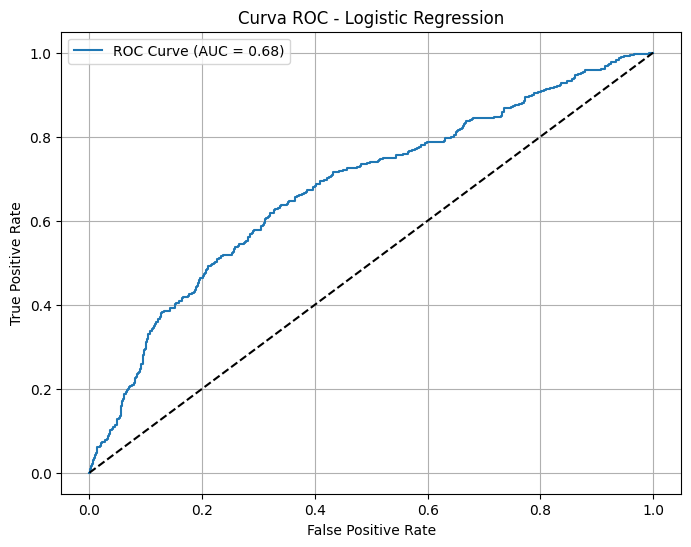

🚨 Top 10 clientes com maior risco de cancelamento:
Índice 922 - Probabilidade de cancelamento: 72.78%
Índice 915 - Probabilidade de cancelamento: 72.69%
Índice 1001 - Probabilidade de cancelamento: 72.05%
Índice 509 - Probabilidade de cancelamento: 71.97%
Índice 795 - Probabilidade de cancelamento: 71.94%
Índice 831 - Probabilidade de cancelamento: 71.78%
Índice 883 - Probabilidade de cancelamento: 71.76%
Índice 502 - Probabilidade de cancelamento: 71.57%
Índice 725 - Probabilidade de cancelamento: 71.49%
Índice 1003 - Probabilidade de cancelamento: 71.33%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, classification_report, confusion_matrix
)

# 1. Dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

categorical_features = ["genero", "nivel_educacional", "tipo_seguro", 
                        "satisfacao_ultima_avaliacao", "canal_venda", "tipo_duracao"]

# 2. Codificação
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)
X_encoded = encoder.fit_transform(X)

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# 4. Modelo
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# 5. Predições
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 6. Avaliação
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🔎 Métricas:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 7. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

# 8. Top clientes com maior risco de churn
top_n = 10
top_indices = np.argsort(y_proba)[-top_n:][::-1]

print(f"🚨 Top {top_n} clientes com maior risco de cancelamento:")
for i in top_indices:
    print(f"Índice {i} - Probabilidade de cancelamento: {y_proba[i]:.2%}")


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, classification_report, confusion_matrix
)

# 1. Dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

categorical_features = ["genero", "nivel_educacional", "canal_venda","faixa_etaria"]

# 2. Codificação
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)
X_encoded = encoder.fit_transform(X)

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# 4. Modelo
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# 5. Predições
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 6. Avaliação
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🔎 Métricas:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 7. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

# 8. Top clientes com maior risco de churn
top_n = 10
top_indices = np.argsort(y_proba)[-top_n:][::-1]

print(f"🚨 Top {top_n} clientes com maior risco de cancelamento:")
for i in top_indices:
    print(f"Índice {i} - Probabilidade de cancelamento: {y_proba[i]:.2%}")


ValueError: A given column is not a column of the dataframe

#### 3.2 RandomForestClassifier (robusto e bom para baseline)


#### Conclusões
----
COM SMOTE e as features originais, o desempenho foi melhor.

SEM SMOTE E FEATURES ORIGINAIS

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.81      0.72       708
           1       0.62      0.43      0.51       520

    accuracy                           0.65      1228
   macro avg       0.64      0.62      0.62      1228
weighted avg       0.64      0.65      0.63      1228

📉 Confusion Matrix:
[[570 138]
 [296 224]]
🔎 Métricas:
Accuracy: 0.6465798045602605
Precision: 0.6187845303867403
Recall: 0.4307692307692308
F1-score: 0.5079365079365079
ROC AUC: 0.6798457192524989


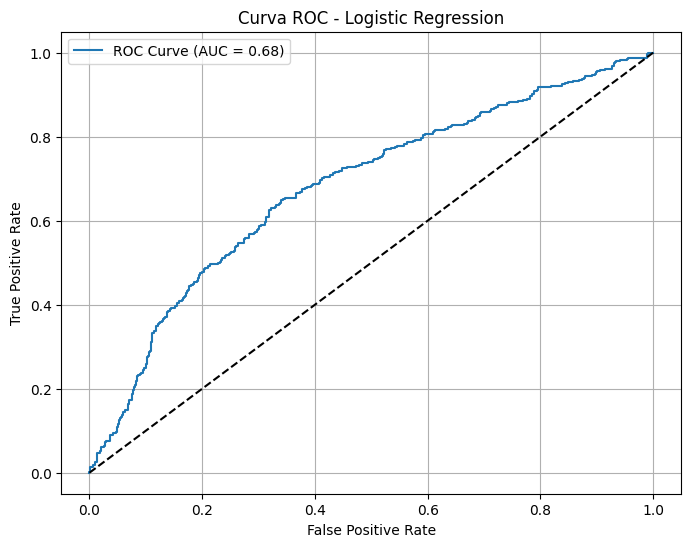

In [ ]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 3. Aplica o SMOTE para balancear a base

# 4. Divide os dados balanceados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 5. Treina o modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


# 6. Avalia o modelo
y_pred = model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🔎 Métricas:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# 7. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


COM SMOTE E FEATURES ORIGINAIS

# VAMOS USAR ESSE AQUI

In [38]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 3. Aplica o SMOTE para balancear a base
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Divide os dados balanceados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Treina o modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


# 6. Avalia o modelo
y_pred = model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       678
           1       0.75      0.58      0.66       752

    accuracy                           0.68      1430
   macro avg       0.69      0.69      0.68      1430
weighted avg       0.69      0.68      0.68      1430

[[534 144]
 [313 439]]


#### 3.3 CatBoostClassifier

SEM SMOTE E FEATURES ORIGINAIS

In [37]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 3. Aplica o SMOTE para balancear a base
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Divide os dados balanceados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Treina o modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


# 6. Avalia o modelo
y_pred = model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       678
           1       0.75      0.58      0.66       752

    accuracy                           0.68      1430
   macro avg       0.69      0.69      0.68      1430
weighted avg       0.69      0.68      0.68      1430

[[534 144]
 [313 439]]
